In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pylab as plt
import numpy as np
from pathlib import Path
import sys
import math

In [2]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

In [3]:
# Directory to save plot

dir_for_figures = Path("/hetghome/antonpr/projects/mceq_vs/results/01_muon_shower")
dir_for_figures = dir_for_figures/"01_muon_run/plots"

# Create path if it doesn't exist
Path(dir_for_figures).mkdir(parents=True, exist_ok=True)

# Fluka data load

In [4]:
fluka_scripts_path = "/hetghome/antonpr/projects/mceq_vs/mceq_vs/src/fluka"
sys.path.insert(0, fluka_scripts_path)
from muon_shower_fluka import muon_shower_data

In [5]:
meta_data_json = "/hetghome/antonpr/projects/mceq_vs/data/fluka/04_muon_showers/alfredo_muons/04_single_muon_plus/meta_data.json"
fluka_muon_shower = muon_shower_data(meta_data_json)

# Corsika intializatioin

In [6]:
corsika_scripts_path = "/hetghome/antonpr/projects/mceq_vs/mceq_vs/src/corsika"
sys.path.insert(0, corsika_scripts_path)
from corsika_h5reader import (corsika_hist_en, 
                              combined_data_en, 
                              corsika_en_theta_2dhist)

In [7]:
# Corsika energy distributions
corsika_data_file = Path("/hetghome/antonpr/projects/mceq_vs/data"
                     "/corsika/03_single_muon_shower/"
                     "01_single_muon_run/01_single_muon.h5")
energy_bins = fluka_muon_shower["mu"][0].en_bins
# energy_bins = mceq.e_bins
chist_en = corsika_hist_en(energy_bins, 
                           h5file=corsika_data_file)

Read file:
.../03_single_muon_shower/01_single_muon_run/01_single_muon.h5
Number of primaries = 2.500000e+06


In [8]:
corsika_en_dists = {}

for pdg in chist_en:
    cors_pdg = {}
    for level in range(5):
        cors_pdg[level] = combined_data_en(chist_en, [pdg], level)
    
    corsika_en_dists[pdg] = cors_pdg

In [9]:
len(corsika_en_dists)

15

In [10]:
def unique_pdg_list(pdgs):
    res = list(set(pdgs))
    res.sort(key=lambda x: (abs(x), x > 0))
    return res

/tmp/ipykernel_3016083/4073691620.py:43: RuntimeWarning: invalid value encountered in divide
  p_norm = hist_dist/tot_num


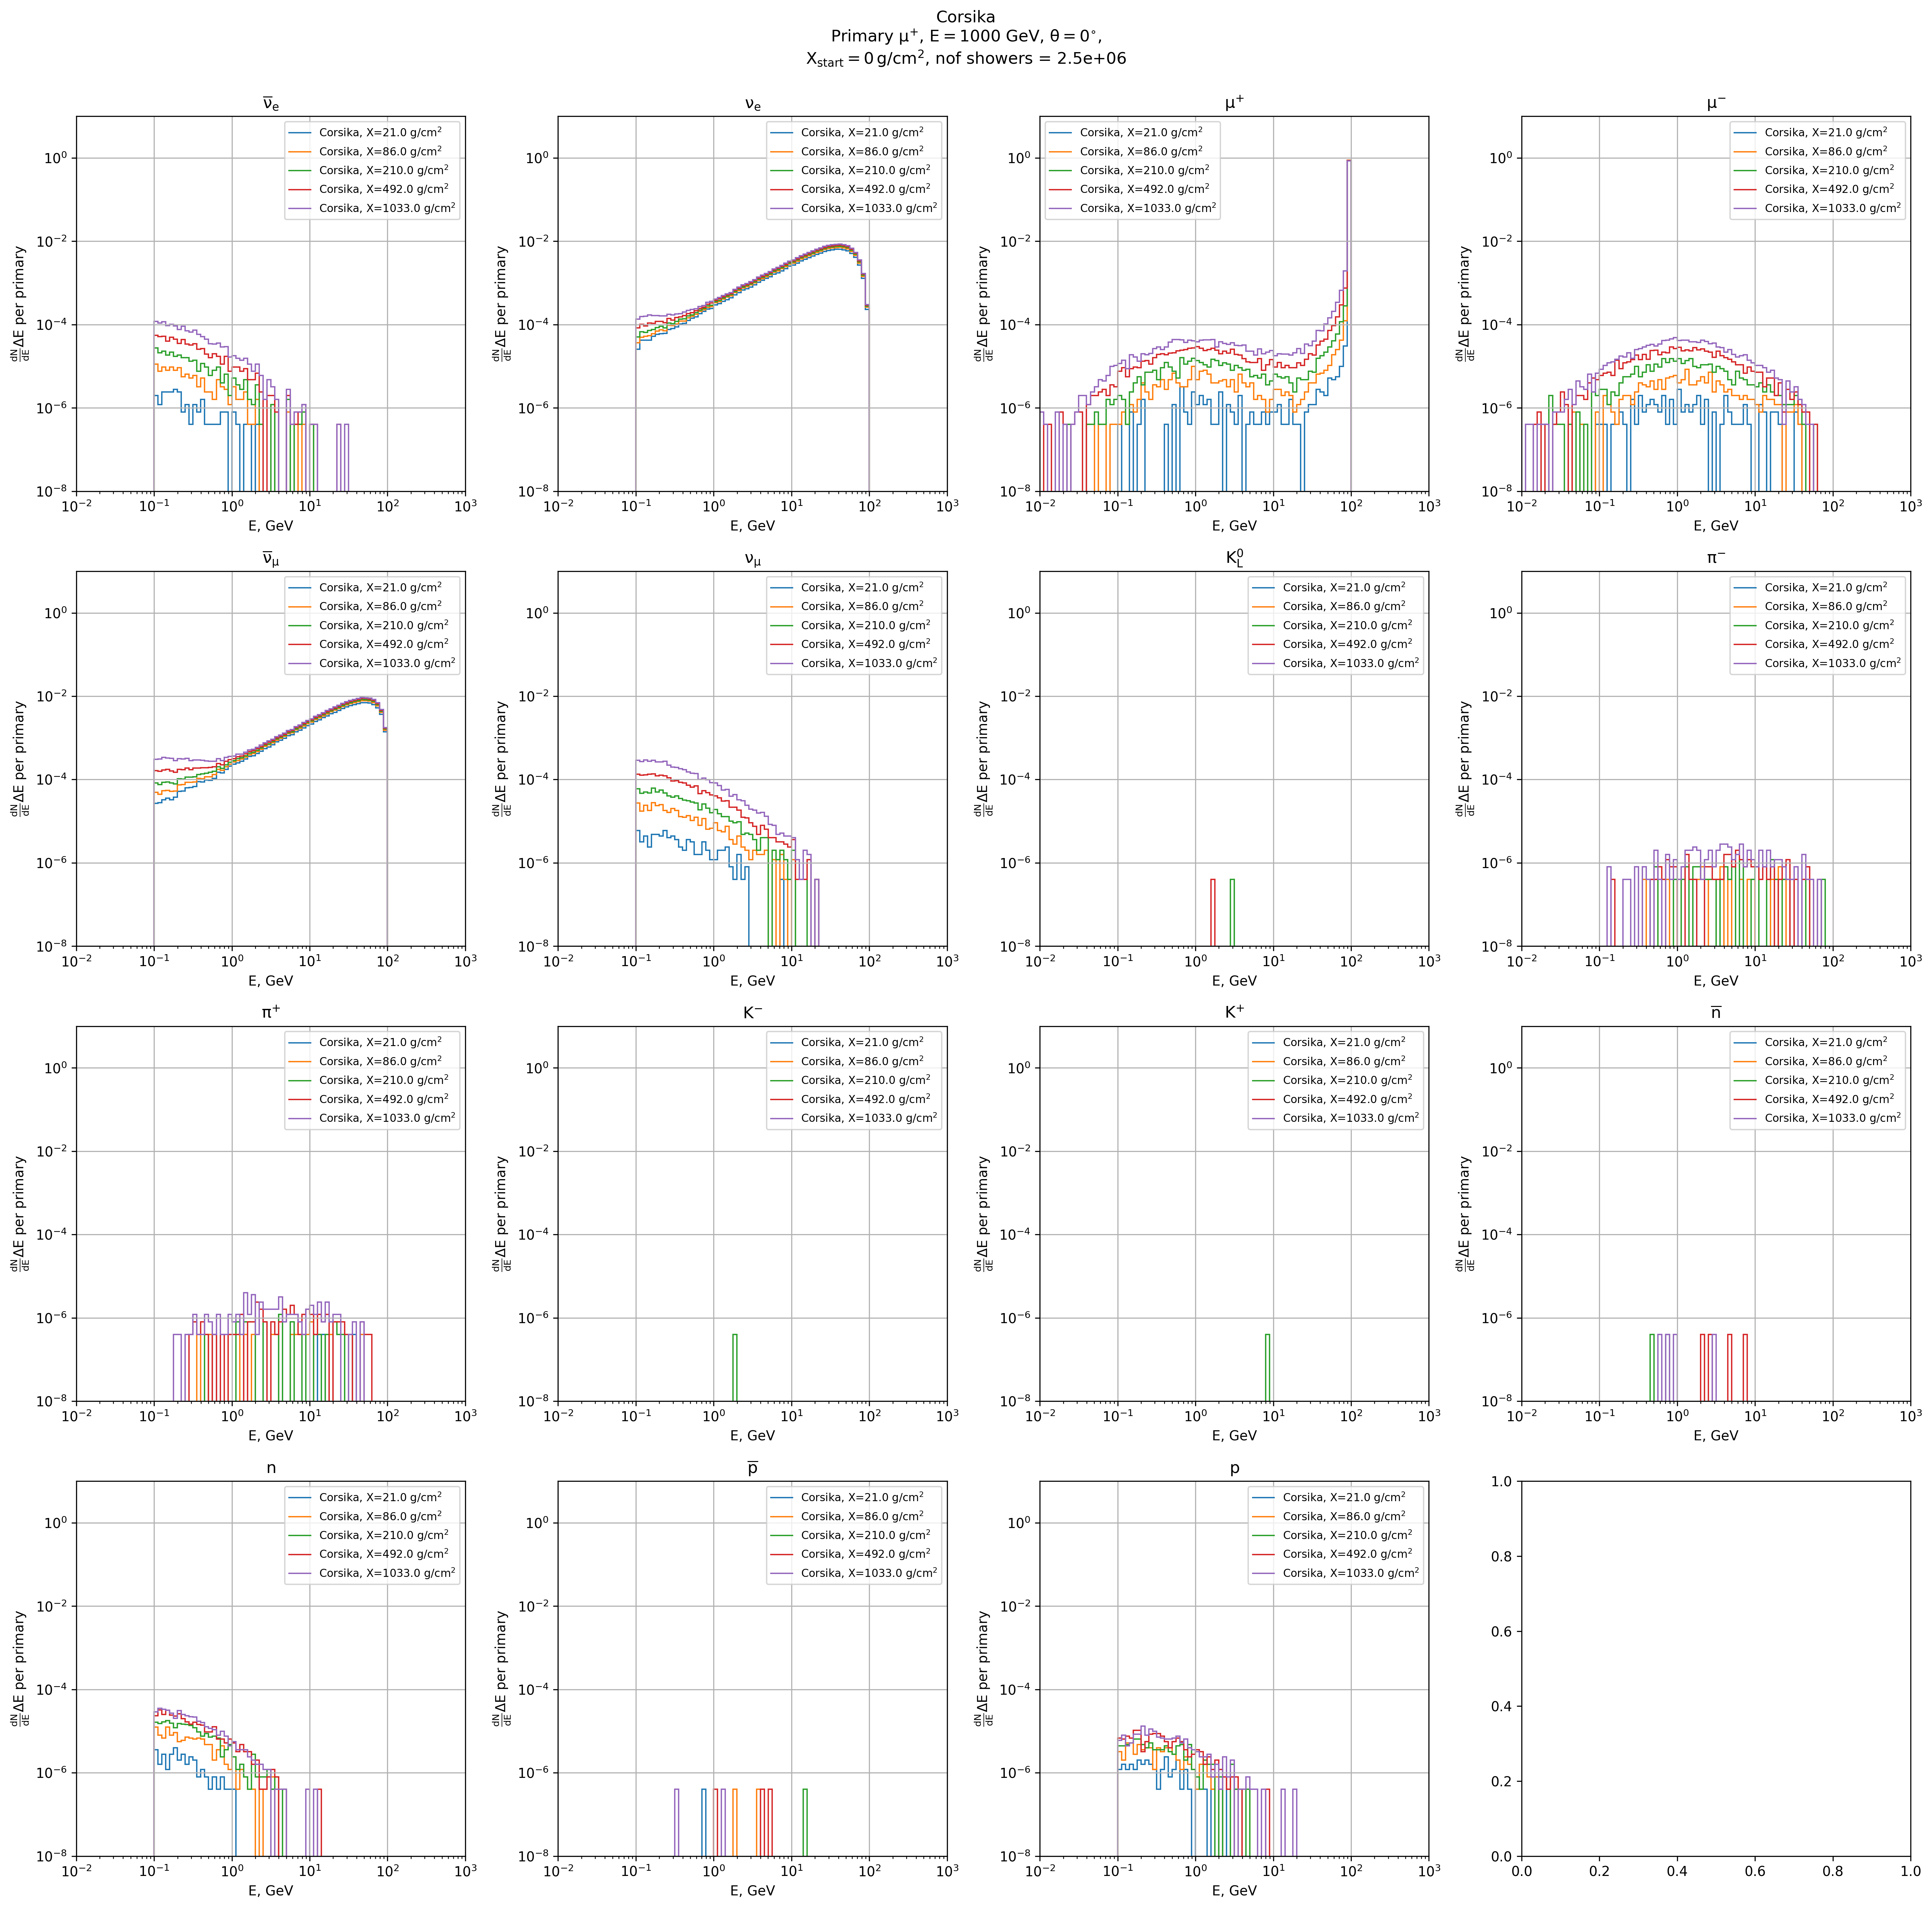

In [11]:
figure_name = "03_muon_100GeV.svg"
figure = plt.figure(figsize=(20, 20))


pdg_list = unique_pdg_list(list(corsika_en_dists.keys()))
ncols = 4
nrows = math.ceil(len(corsika_en_dists)/ncols)

grid_spec = figure.add_gridspec(nrows=nrows, 
                                ncols=ncols, 
                                width_ratios=[1, 1, 1, 1],
                                height_ratios=[1, 1, 1, 1])

axis = []
for irow in range(nrows):
    axis_row = []
    for icol in range(ncols):
        axis_row.append(figure.add_subplot(grid_spec[irow, icol]))
    axis.append(axis_row)


line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

sigma = 1
xdepth_num = 5

ipdg = 0
for irow in range(nrows):
    for icol in range(ncols):
        ax = axis[irow ][icol]
        
        try:
            pdg0 = pdg_list[ipdg]
        except:
            continue
            
        for ixdepth in range(xdepth_num):    
            hist0 = corsika_en_dists[pdg0][ixdepth]
            num_primaries = hist0[4]
    
            hist_dist = hist0[0]
            tot_num = np.sum(hist_dist)
            p_norm = hist_dist/tot_num
            error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
            fraction = tot_num/num_primaries
            dist_to_plot = hist_dist/num_primaries
            errors_to_plot = error_cors/num_primaries
            bins_to_plot = hist0[1]
            # print(f"pdg={pdg0:<6} {hist0[3]:10s}: number={tot_num:<10} fraction={fraction}")
    
            line = ax.stairs(dist_to_plot, bins_to_plot, 
                            label = (f"Corsika, {hist0[3]} " + r"$g/cm^2$"),
                            color = line_colors[ixdepth],
                            linestyle = "-")
    
            # line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
            #                 baseline = dist_to_plot-errors_to_plot, 
            #                 fill=True,
            #                 alpha = 0.2, 
            #                 color = line_colors[ixdepth],
            #                 linestyle = "-")
    
        plabel = hist0[2]
        ax.set_title(f"{plabel}")

        ax.set_xscale("log")
        ax.set_xlim(1e-2, 1e3)
        ax.set_xlabel("E, GeV")

        ax.set_yscale("log")
        ax.set_ylim(1e-8, 1e1)
        ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
        ax.legend(fontsize="8")
        ax.grid()
        ipdg += 1         
        # print("-----\n")
  
figure.suptitle(r"Corsika" + "\n" + r"Primary "  + 
            r"$\mu^{+}$, $E=1000$ GeV, $\theta=0^{\circ}$," + "\n" 
            + r"$X_{start} = 0\,\mathrm{g/cm^2}$, nof showers = 2.5e+06" + "\n\n")

figure.tight_layout()   
plt.savefig(dir_for_figures/figure_name)  

In [52]:
pdg_list = list(fluka_muon_shower.keys())
ncols = 3
nrows = math.ceil(len(pdg_list)/ncols)

print(ncols, nrows)

3 2


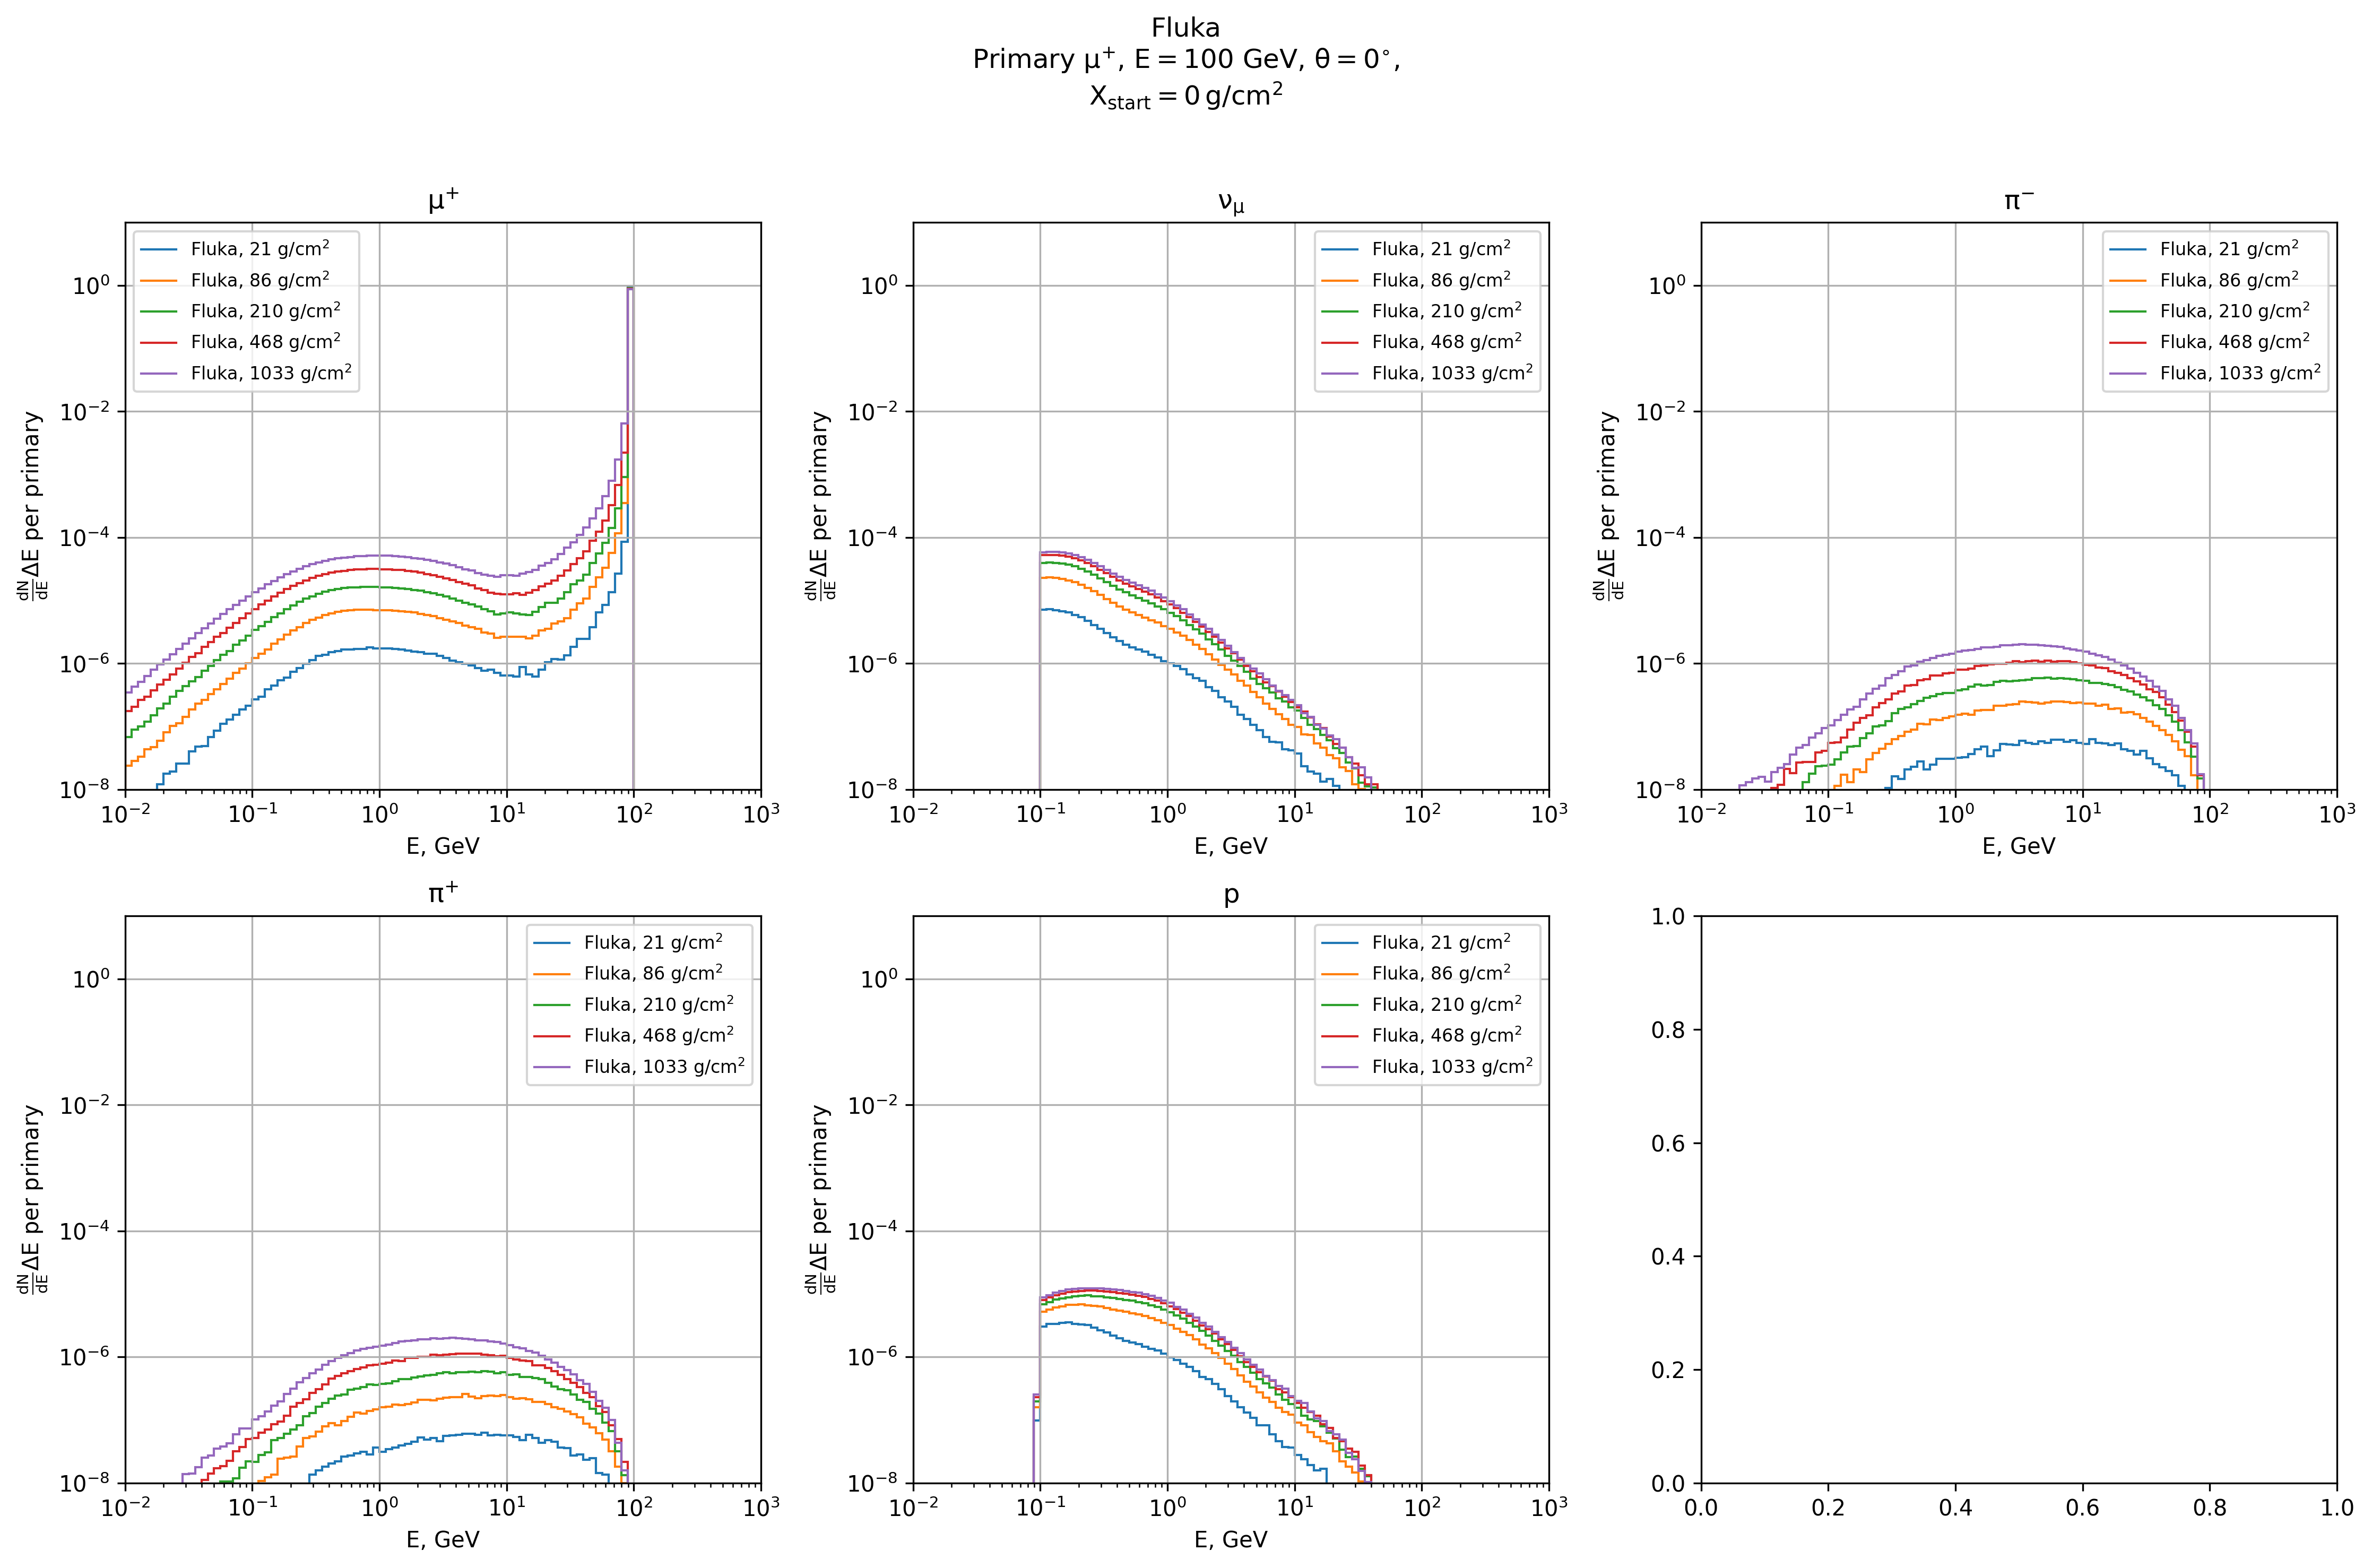

In [12]:
# Fluka plots
figure_name = "04_flukaMuon_100GeV.svg"
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pdg_list = list(fluka_muon_shower.keys())
ncols = 3
nrows = math.ceil(len(pdg_list)/ncols)

figure = plt.figure(figsize=(15, 10))
grid_spec = figure.add_gridspec(nrows=nrows, 
                                ncols=ncols, 
                                width_ratios=[1, 1, 1],
                                height_ratios=[1, 1])

axis = []
for irow in range(nrows):
    axis_row = []
    for icol in range(ncols):
        axis_row.append(figure.add_subplot(grid_spec[irow, icol]))
    axis.append(axis_row)


ipdg = 0
for irow in range(nrows):
    for icol in range(ncols):
        ax = axis[irow][icol]
        
        try:
            pdg0 = pdg_list[ipdg]
        except:
            continue
            
        inv_order = len(fluka_muon_shower[pdg0])
        for ixdepth, _ in enumerate(fluka_muon_shower[pdg0]):
            hist0 = fluka_muon_shower[pdg0][inv_order - ixdepth - 1]
            dist_to_plot = hist0.val
            bins_to_plot = hist0.en_bins
            ax.stairs(dist_to_plot *
                      (bins_to_plot[1:] - bins_to_plot[:-1])
                      , bins_to_plot, 
                        label = (f"Fluka, {hist0.xdepth} " + r"$g/cm^2$"),
                        color = line_colors[ixdepth],
                        linestyle = "-")

            plabel = hist0.particle_latex_name
            ax.set_title(f"{plabel}")

            ax.set_xscale("log")
            ax.set_xlim(1e-2, 1e3)
            ax.set_xlabel("E, GeV")

            ax.set_yscale("log")
            ax.set_ylim(1e-8, 1e1)
            ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
            ax.legend(fontsize="8")
            ax.grid()

        ipdg += 1

  
figure.suptitle(r"Fluka" + "\n" + r"Primary "  + 
            r"$\mu^{+}$, $E=100$ GeV, $\theta=0^{\circ}$," + "\n" 
            + r"$X_{start} = 0\,\mathrm{g/cm^2}$" + "\n\n")

figure.tight_layout()   
plt.savefig(dir_for_figures/figure_name)  

/tmp/ipykernel_3016083/3350902832.py:54: RuntimeWarning: invalid value encountered in divide
  p_norm = hist_dist/tot_num


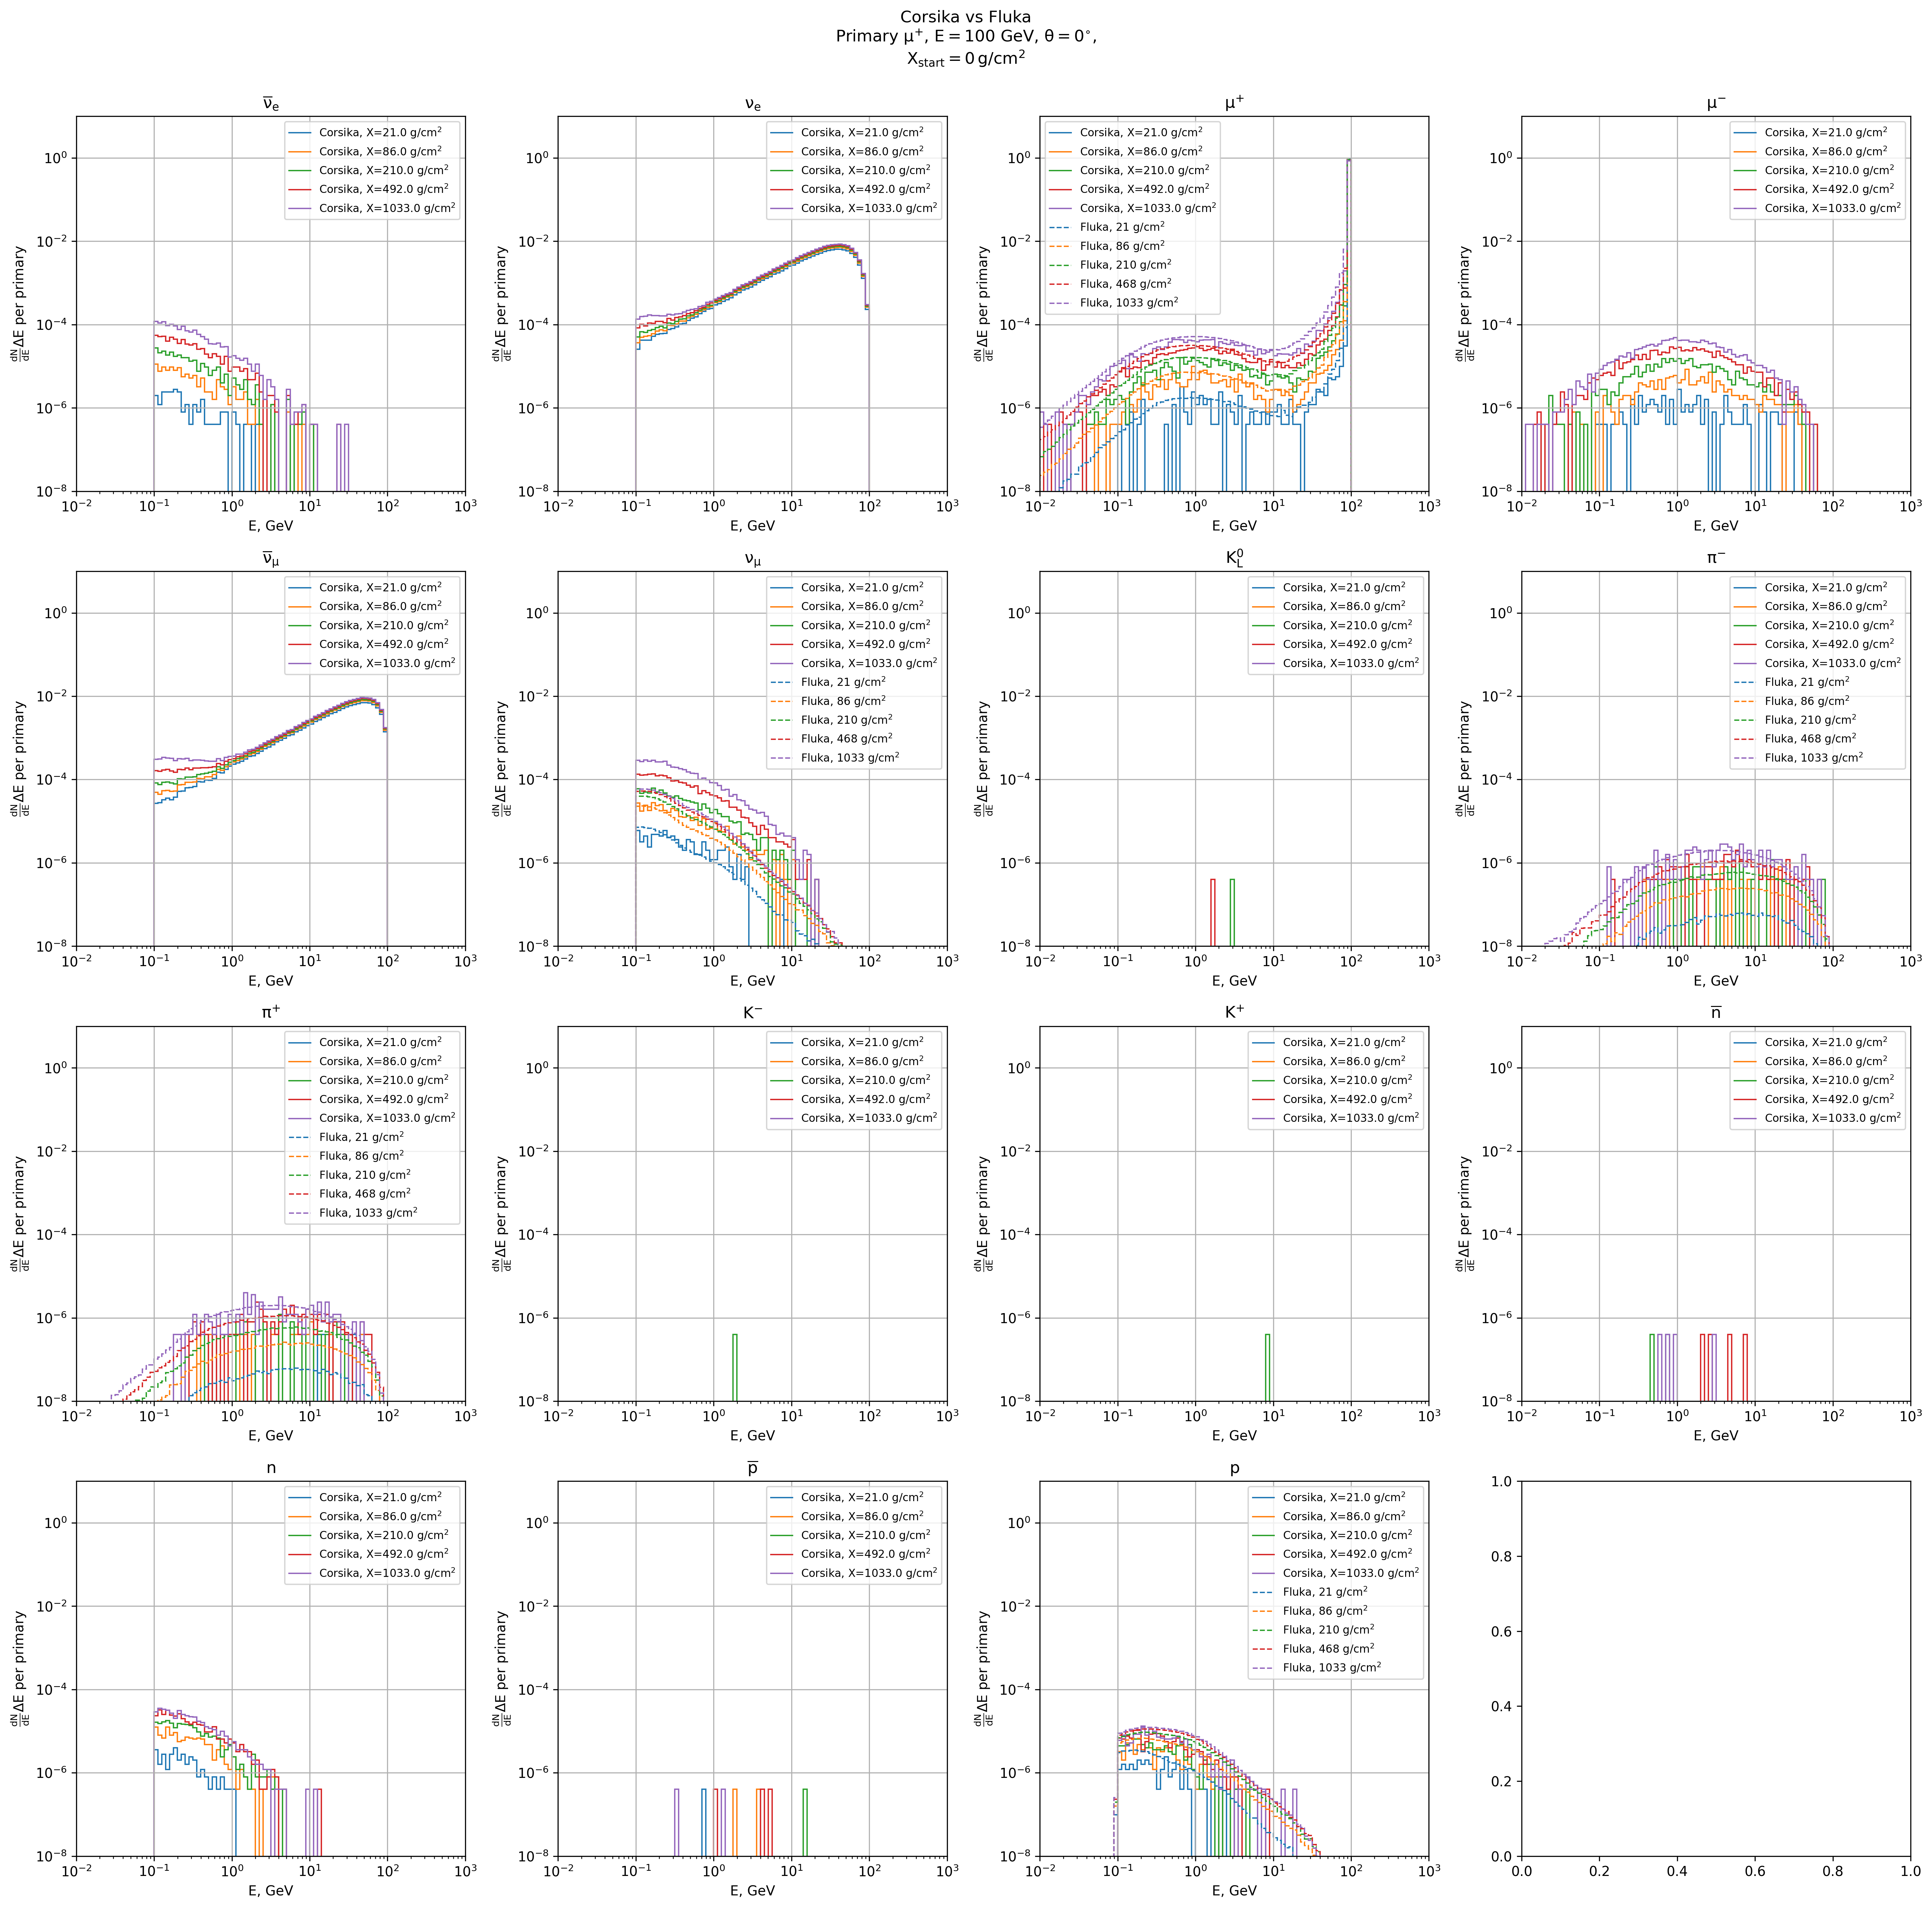

In [13]:
# Fluka vs Corsika comparison
figure_name = "05_flukaCorsikaMuon_100GeV.svg"
figure = plt.figure(figsize=(20, 20))


pdg_list = unique_pdg_list(list(corsika_en_dists.keys()))
ncols = 4
nrows = math.ceil(len(corsika_en_dists)/ncols)

grid_spec = figure.add_gridspec(nrows=nrows, 
                                ncols=ncols, 
                                width_ratios=[1, 1, 1, 1],
                                height_ratios=[1, 1, 1, 1])

axis = []
for irow in range(nrows):
    axis_row = []
    for icol in range(ncols):
        axis_row.append(figure.add_subplot(grid_spec[irow, icol]))
    axis.append(axis_row)


line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map between Corsika to Fluka
fluka_cors_label_map = {-13 :"mu",
                        14 : "numu",
                        -211 :"pi-",
                        211 : "pi+",
                        2212 :"p"
                        }



sigma = 1
xdepth_num = 5

ipdg = 0
for irow in range(nrows):
    for icol in range(ncols):
        ax = axis[irow ][icol]
        
        try:
            pdg0 = pdg_list[ipdg]
        except:
            continue
            
        for ixdepth in range(xdepth_num):    
            hist0 = corsika_en_dists[pdg0][ixdepth]
            num_primaries = hist0[4]
    
            hist_dist = hist0[0]
            tot_num = np.sum(hist_dist)
            p_norm = hist_dist/tot_num
            error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
            fraction = tot_num/num_primaries
            dist_to_plot = hist_dist/num_primaries
            errors_to_plot = error_cors/num_primaries
            bins_to_plot = hist0[1]
            # print(f"pdg={pdg0:<6} {hist0[3]:10s}: number={tot_num:<10} fraction={fraction}")
    
            line = ax.stairs(dist_to_plot, bins_to_plot, 
                            label = (f"Corsika, {hist0[3]} " + r"$g/cm^2$"),
                            color = line_colors[ixdepth],
                            linestyle = "-")
            
            
            
    
            # line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
            #                 baseline = dist_to_plot-errors_to_plot, 
            #                 fill=True,
            #                 alpha = 0.2, 
            #                 color = line_colors[ixdepth],
            #                 linestyle = "-")
        
        try:
            pdg_fluka = fluka_cors_label_map[pdg0]
          
            inv_order = len(fluka_muon_shower[pdg_fluka])
            for ixdepth, _ in enumerate(fluka_muon_shower[pdg_fluka]):
                hist0_fl = fluka_muon_shower[pdg_fluka][inv_order - ixdepth - 1]
                dist_to_plot = hist0_fl.val
                bins_to_plot = hist0_fl.en_bins
                ax.stairs(dist_to_plot * (bins_to_plot[1:] - bins_to_plot[:-1]),
                            bins_to_plot, 
                            label = (f"Fluka, {hist0_fl.xdepth} " + r"$g/cm^2$"),
                            color = line_colors[ixdepth],
                            linestyle = "--")
        except:
            pass        
    
        plabel = hist0[2]
        ax.set_title(f"{plabel}")

        ax.set_xscale("log")
        ax.set_xlim(1e-2, 1e3)
        ax.set_xlabel("E, GeV")

        ax.set_yscale("log")
        ax.set_ylim(1e-8, 1e1)
        ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
        # plt.yscale("log")
        # plt.xlim(0.08, 0.1)
        # ax.set_ylim(0, 0.032)
        ax.legend(fontsize="8")
        ax.grid()
        ipdg += 1         
        # print("-----\n")
  
figure.suptitle(r"Corsika vs Fluka" + "\n" + r"Primary "  + 
            r"$\mu^{+}$, $E=100$ GeV, $\theta=0^{\circ}$," + "\n" 
            + r"$X_{start} = 0\,\mathrm{g/cm^2}$" + "\n\n")

figure.tight_layout()   
plt.savefig(dir_for_figures/figure_name) 

/tmp/ipykernel_3016083/824711170.py:50: RuntimeWarning: invalid value encountered in divide
  ax.stairs(dist_to_plot_cors/dist_to_plot_fluka, bins_to_plot,


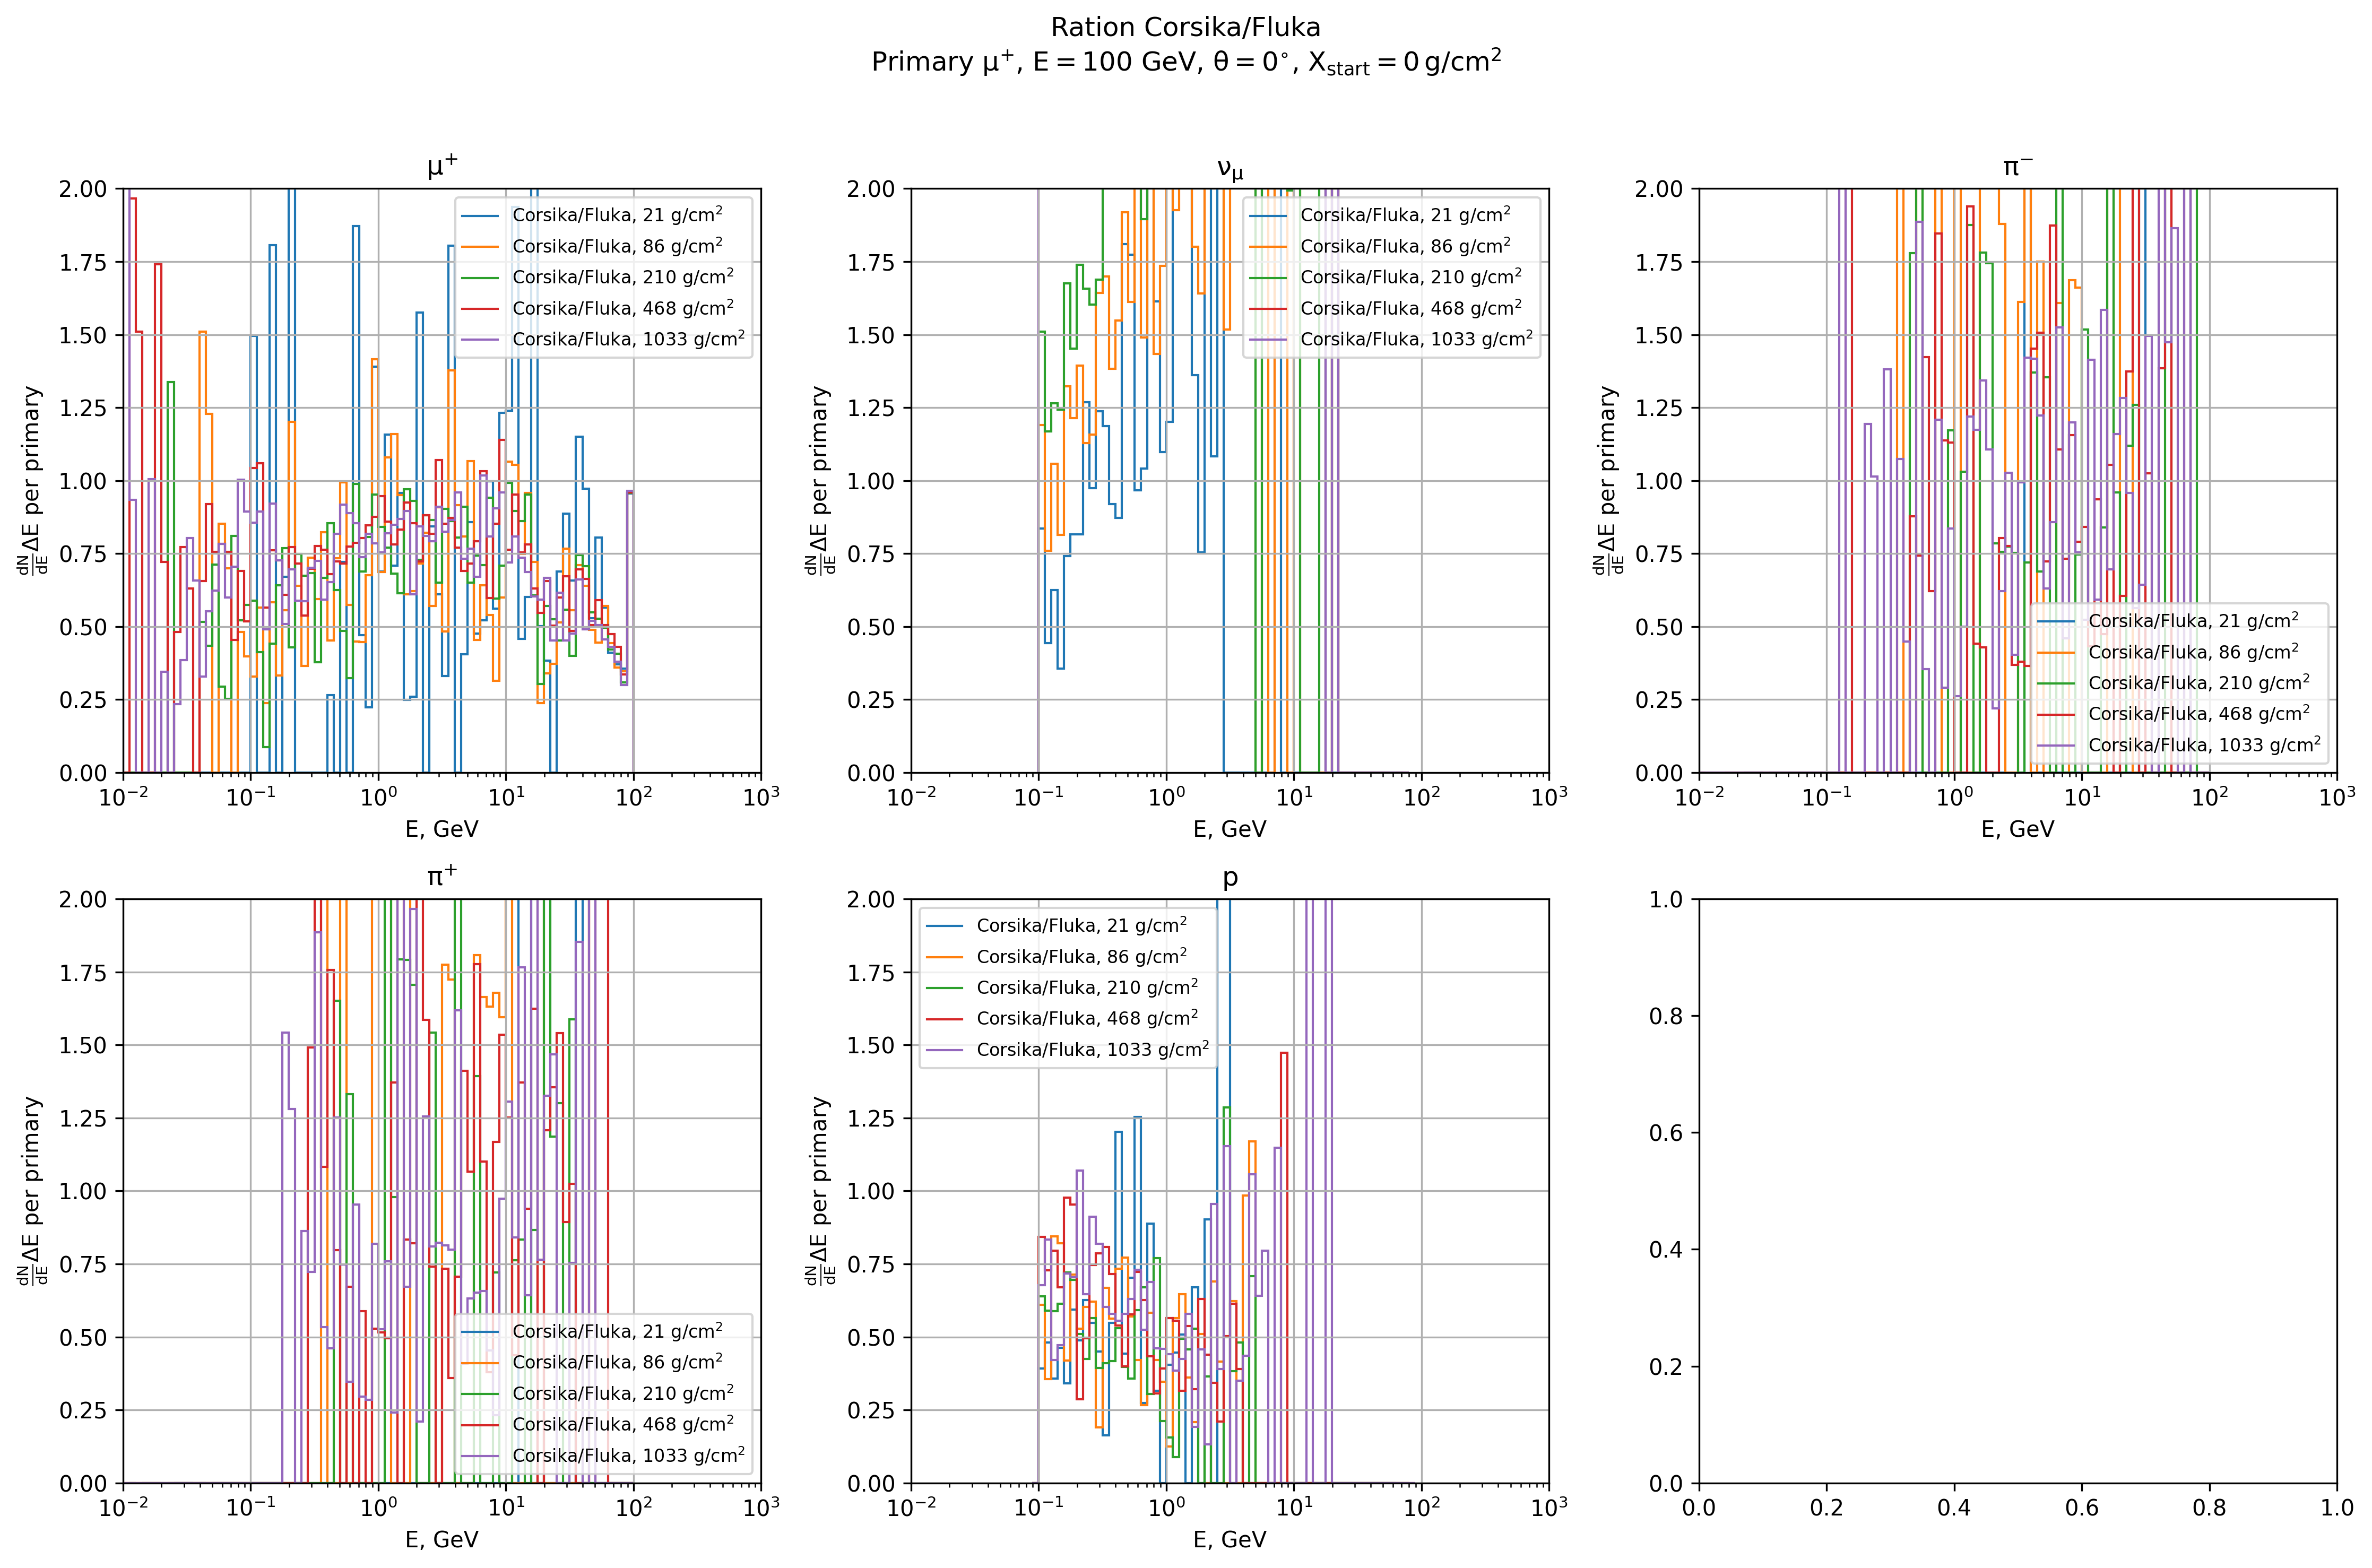

In [17]:
# Fluka vs Corsika ratio plots
figure_name = "06_flukaMuon_ratio_100GeV.svg"
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pdg_list = list(fluka_muon_shower.keys())
ncols = 3
nrows = math.ceil(len(pdg_list)/ncols)

figure = plt.figure(figsize=(15, 10))
grid_spec = figure.add_gridspec(nrows=nrows, 
                                ncols=ncols, 
                                width_ratios=[1, 1, 1],
                                height_ratios=[1, 1])

cors_fluka_label_map = {"mu" : -13,
                        "numu" : 14,
                        "pi-": -211,
                        "pi+": 211,
                        "p" : 2212
                        }

axis = []
for irow in range(nrows):
    axis_row = []
    for icol in range(ncols):
        axis_row.append(figure.add_subplot(grid_spec[irow, icol]))
    axis.append(axis_row)


ipdg = 0
for irow in range(nrows):
    for icol in range(ncols):
        ax = axis[irow][icol]
        
        try:
            pdg0 = pdg_list[ipdg]
        except:
            continue
                
            
        inv_order = len(fluka_muon_shower[pdg0])
        for ixdepth, _ in enumerate(fluka_muon_shower[pdg0]):
            
            hist0_cors = corsika_en_dists[cors_fluka_label_map[pdg0]][ixdepth]
            dist_to_plot_cors = hist0_cors[0]/hist0_cors[4]
            
            
            hist0 = fluka_muon_shower[pdg0][inv_order - ixdepth - 1]
            dist_to_plot_fluka = hist0.val * (bins_to_plot[1:] - bins_to_plot[:-1])
            bins_to_plot = hist0.en_bins
            ax.stairs(dist_to_plot_cors/dist_to_plot_fluka, bins_to_plot, 
                        label = (f"Corsika/Fluka, {hist0.xdepth} " + r"$g/cm^2$"),
                        color = line_colors[ixdepth],
                        linestyle = "-")

            plabel = hist0.particle_latex_name
            ax.set_title(f"{plabel}")

            ax.set_xscale("log")
            ax.set_xlim(1e-2, 1e3)
            ax.set_xlabel("E, GeV")

            # ax.set_yscale("log")
            ax.set_ylim(0, 2e0)
            ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
            ax.legend(fontsize="8")
            ax.grid()

        ipdg += 1

  
figure.suptitle(r"Ration Corsika/Fluka" + "\n" + r"Primary "  + 
            r"$\mu^{+}$, $E=100$ GeV, $\theta=0^{\circ}$, " 
            + r"$X_{start} = 0\,\mathrm{g/cm^2}$" + "\n\n")

figure.tight_layout()   
plt.savefig(dir_for_figures/figure_name)  